# Autoencoder and Image Classification
## by Jose Quinatoa

### **Objective:**
The objective of this project is to develop an algorithm that efficiently recognizes Arabic digits (1 to 9) from user-generated handwriting. To address the constraint of minimizing data usage, an autoencoder will be implemented to compress and store each hand-drawn digit representation with optimal memory efficiency.

### **Problem Statement:**
The proposed solution involves a two-step process: first, encoding the hand-drawn digits using an autoencoder to generate compact representations; second, utilizing Convolutional Neural Networks (CNNs) to train a classification model. The CNN will be trained on the encoded images to classify each digit accurately. It is essential to note that any new image to be analyzed must undergo encoding before being processed by the classification model.

### **Challenge:**
The primary challenge lies in designing an efficient autoencoder that captures the distinctive features of Arabic digits while minimizing memory usage. Additionally, the CNN must be trained to generalize well to diverse handwriting styles and accurately classify encoded representations. This project aims to provide a robust solution for recognizing Arabic handwritten digits with minimal data requirements, making it applicable for various user scenarios.

### **Data:**
Arabic digits correspond to Roman digits according to the table below (N.Das, A. Mollah, S. Saha, S. Haque, 2010, https://arxiv.org/abs/1003.1891):

### **1) Libraries**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam
from keras.layers import Input, Dense, Flatten
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from keras.models import load_model
import random

### **2) Importing datasets**

In [2]:
# Load the CSV file into a pandas DataFrame
images_df = pd.read_csv("0) datasets//csvImages 10k x 784.csv", header=None).values
labels = np.array([j for i in range(1000) for j in range(10)])

images_dataset = images_df[0:8000]
images_dataset_testing = images_df[8000:10000]
labels_dataset = labels[0:8000]
labels_dataset_testing = labels[8000:10000]

### **3) Exploration**

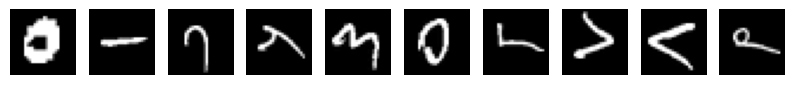

In [3]:
def print_sample(image_dataset):
    images =  image_dataset.reshape(-1, 28, 28)
    # Display images using Matplotlib
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

    plt.show()
    
print_sample(images_dataset)

### **4. Autoencoding**

In [4]:
def image_processing(image_dataset):
    processed_images =  image_dataset.reshape(-1, 28, 28).reshape(-1, 28 ** 2)
    # Normalize the data by dividing each value by 255
    processed_images = processed_images / 255.0
    return processed_images    

def autoencoder_results_plot(image_datasets, n_samples, samples_by_row,
                            images_size, cmap, plot_title=None,
                            font_size_title=None, subplot_subtitles=None,
                            font_size_subtitles=None):
    width = len(image_datasets)*samples_by_row*images_size
    height = samples_by_row*images_size
    grid_col = len(image_datasets)
    grid_row = 1

    fig = plt.figure(figsize=(width, height))
    fig.suptitle(plot_title, fontsize=font_size_title)
    gs0 = gridspec.GridSpec(grid_row, grid_col, figure=fig)

    for g, images_data, subtitle in zip(range(len(image_datasets)), image_datasets, subplot_subtitles):
        gs00 = gridspec.GridSpecFromSubplotSpec(
            samples_by_row, samples_by_row, subplot_spec=gs0[g])

        for i in range(n_samples):
            ax = fig.add_subplot(gs00[i])
            ax.imshow(images_data[i], cmap=cmap)
            ax.axis('off')
            if i == 0:
                ax.set_title(
                    subtitle, fontsize=font_size_subtitles, loc='left')

    plt.subplots_adjust(wspace=0.05, hspace=0.01)
    plt.show()
    

def autoencoder_generator(n_epochs, pixels, images):
    pixel = pixels
    pixels = pixels**2

    # Define the input layer with the same dimensions as your data
    input_stage = Input(shape=(784,))
    
    # Encoder
    hidden_encoding_1 = Dense(round((((784-pixels)/3))*2.2+pixels, 0), activation="gelu")(input_stage) 
    hidden_encoding_2 = Dense(round((((784-pixels)/3))*1.3+pixels, 0), activation="gelu")(hidden_encoding_1)
    
    encoding_stage = Dense(pixels, activation="gelu")(hidden_encoding_2)
    
    # Decoder
    hidden_decoding_3 = Dense(round((((784-pixels)/3))*1.3+pixels, 0), activation="gelu")(encoding_stage) 
    hidden_decoding_4 = Dense(round((((784-pixels)/3))*2.3+pixels, 0), activation="gelu")(hidden_decoding_3)
    
    decoding_stage = Dense(784, activation='sigmoid')(hidden_decoding_4)
    
    # Build the autoencoder model
    autoencoder = Model(input_stage, decoding_stage)
    
    # Compile the autoencoder
    autoencoder.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=0.0001))
    
    print(f'--> /!\ Autoencoder Model Summary - {pixel} pixels\n')
    autoencoder.summary()
    
    # Train the autoencoder
    history = autoencoder.fit(images, images, epochs=n_epochs, verbose=0)
    print(f'--> Loss: {history.history["loss"][-1]}')
    
    # Create an encoder model (input to encoding stage)
    encoder = Model(input_stage, encoding_stage)
    encoder.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=0.0001))
    
    # Save the encoder model
    encoder.save(f'1) encoders/encoder_{pixel}x{pixel}_pixels.h5')
    
    # Create a decoder model (encoding stage to decoding stage)
    decoder_input = Input(shape=(pixels,))
    decoder_hidden_3 = autoencoder.layers[-3](decoder_input)
    decoder_hidden_4 = autoencoder.layers[-2](decoder_hidden_3)
    decoder_output = autoencoder.layers[-1](decoder_hidden_4)
    
    decoder = Model(decoder_input, decoder_output)
    decoder.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=0.0001))
    
    # Save the decoder model
    decoder.save(f'2) decoders/decoder_{pixel}x{pixel}_pixels.h5')
    
    return encoder, decoder

def encoded_images(encoder, image_dataset, pixels):
    encoded_images = encoder.predict(image_processing(image_dataset), verbose=0).reshape((-1,pixels,pixels))*255
    encoded_images = encoded_images.reshape((encoded_images.shape[0], pixels, pixels, 1))
    return encoded_images

def decoded_images(decoder, image_dataset):
    flattened_encoder_output = Flatten()(image_dataset)
    decoded_images = decoder.predict(flattened_encoder_output,verbose=0).reshape((-1, 28, 28)) * 255
    return decoded_images
    


* ##### Autoencoders - Experiments

* Experimenting and plotting results when analyzing autoencoders is crucial because it helps in understanding how different configurations impact data compression and feature extraction. Here the results of the experiments:


| Experiment     | Input Layer | Hidden Layer 1  | Hidden Layer 2  | Encoding Layer | Hidden Layer 3  | Hidden Layer 4  | Decoding Layer |Activation Function|Output Function| Optimizer | Learning Rate | Loss Function       | Epochs | Loss Score |
|----------------|-------------|-----------------|-----------------|----------------|-----------------|-----------------|----------------|-------------------|---------------|-----------|---------------|---------------------|--------|------------|
| 8x8 pixels     | 784         | 592             | 376             | 64             | 376             | 592             | 784            |gelu               |softmax        | Nadam     | 0.0001        | mean_squared_error  | 700    | 0.000494   |
| 4x4 pixels     | 784         | 579             | 349             | 16             | 349             | 579             | 784            |gelu               |softmax        | Nadam     | 0.0001        | mean_squared_error  | 1000   | 0.0015     |

* Encoder Experiment Results:

|Encoder           | Status        | Width | Height | Pixels | Bytes per Pixel  | Total Bytes per Image  | Total Images | Total Bytes | Rate of Saving    |
|------------------|---------------|-------|--------|--------|------------------|------------------------|--------------|-------------|-------------------|
|------------------| Original      | 28    | 28     | 784    | 4                | 3,136                  | 10,000       | 31,356,864  | 00.00%            |
|Autoencoder_8x8p  | Readable      | 8     | 8      | 64     | 4                | 256                    | 10,000       | 2,559,744   | 91.84%            |
|Autoencoder_4x4p  | No Readable   | 4     | 4      | 16     | 4                | 64                     | 10,000       | 639,936     | 97.96%            |

--> /!\ Autoencoder Model Summary - 8 pixels

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 592)               464720    
                                                                 
 dense_1 (Dense)             (None, 376)               222968    
                                                                 
 dense_2 (Dense)             (None, 64)                24128     
                                                                 
 dense_3 (Dense)             (None, 376)               24440     
                                                                 
 dense_4 (Dense)             (None, 616)               232232    
                                                                 
 dense_5 (Dense

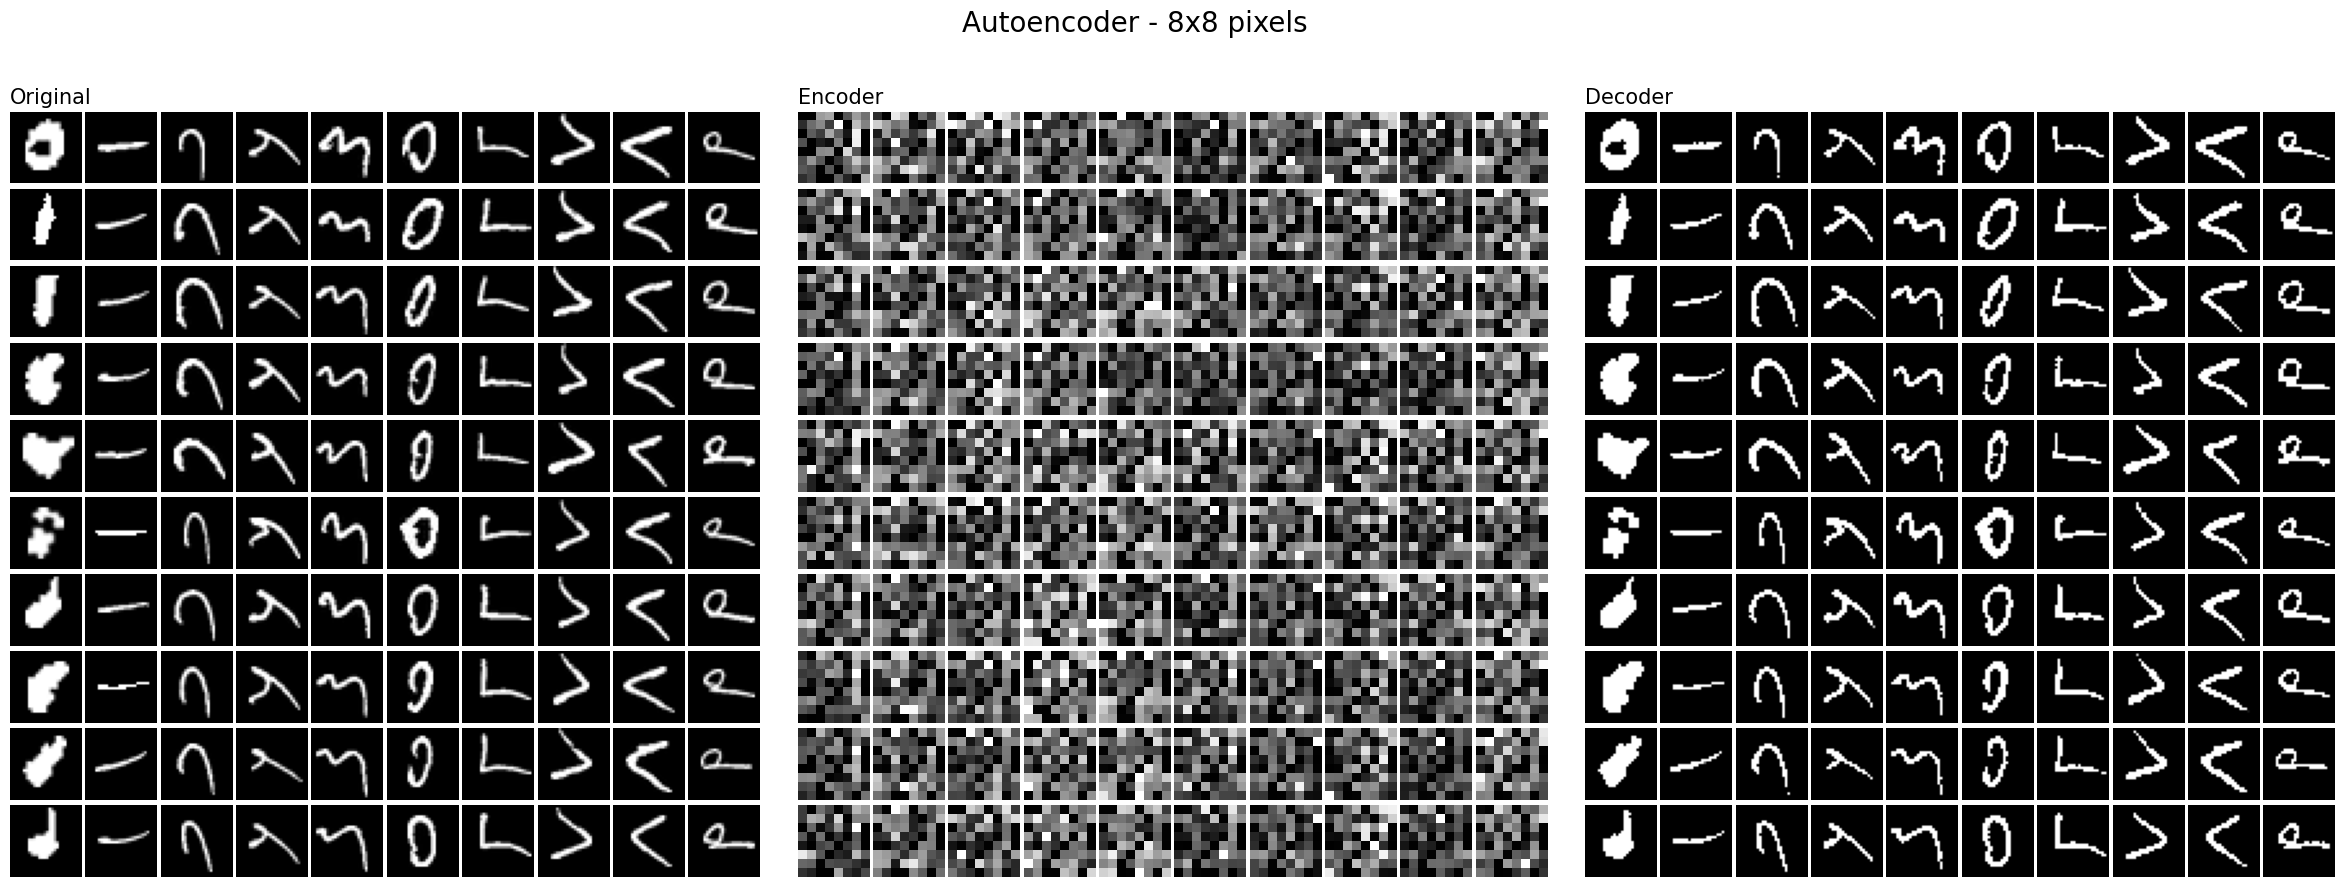

--> /!\ Autoencoder Model Summary - 4 pixels

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 579)               454515    
                                                                 
 dense_7 (Dense)             (None, 349)               202420    
                                                                 
 dense_8 (Dense)             (None, 16)                5600      
                                                                 
 dense_9 (Dense)             (None, 349)               5933      
                                                                 
 dense_10 (Dense)            (None, 605)               211750    
                                                                 
 dense_11 (De

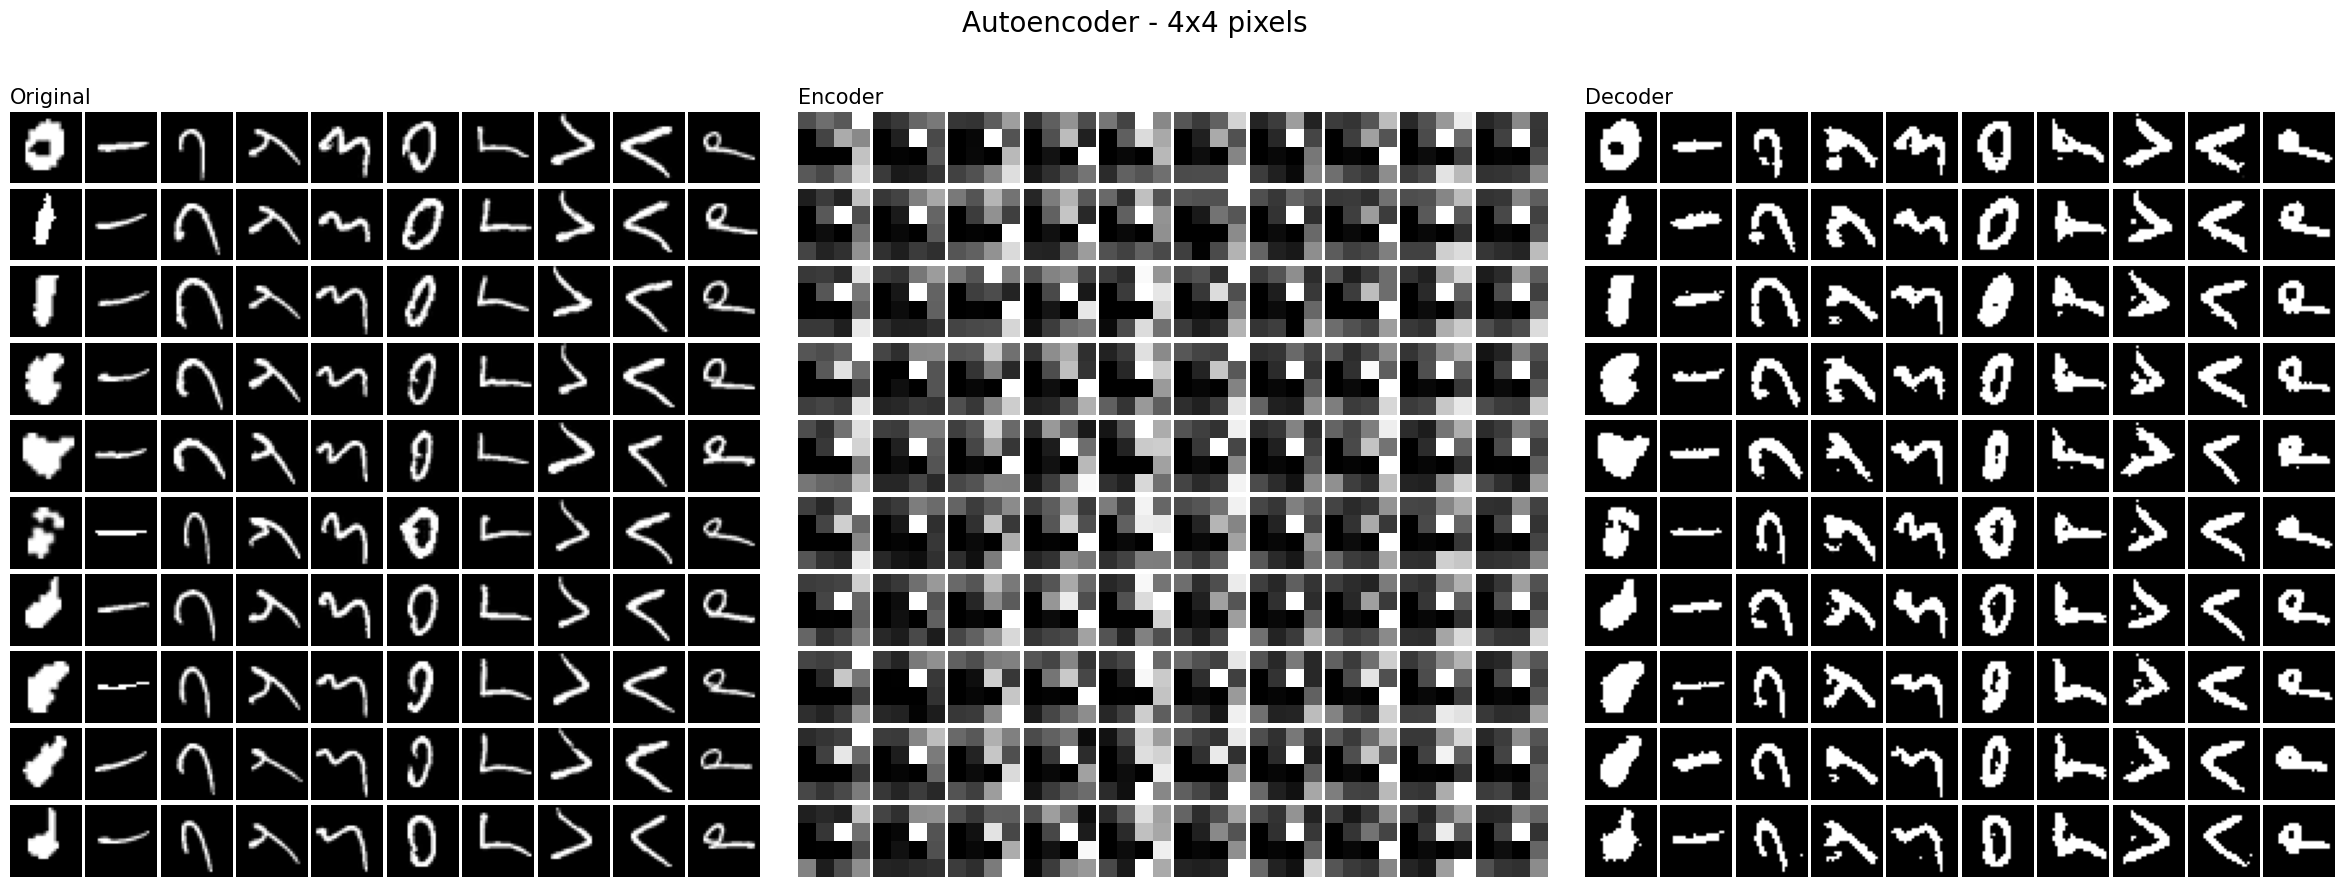

In [5]:
pixels = [8, 4]
epochs = [800, 1000] 

for p,e in zip(pixels, epochs):
    encoder, decoder = autoencoder_generator(n_epochs=e, 
                                            pixels=p, 
                                            images= image_processing(images_dataset))

    original_images = images_dataset[:100].reshape(-1, 28, 28)*255
    encoder_output = encoded_images(encoder, images_dataset[:100], p)
    decoder_output = decoded_images(decoder, encoder_output)

    image_datasets = [original_images, encoder_output, decoder_output]

    autoencoder_results_plot(image_datasets=image_datasets,
                             n_samples=100,
                             samples_by_row=10,
                             images_size=1,
                             cmap='gray',
                             plot_title=f'Autoencoder - {p}x{p} pixels',
                             font_size_title=20,
                             subplot_subtitles=['Original','Encoder','Decoder'],
                             font_size_subtitles=15)

### **5. Image Classification**

In [6]:
# Image data generator
class BatchSize:
    def __init__(self,x_features,y_labels, batch_size):
        self.batch_size = batch_size
        self.x = x_features
        self.y = y_labels
        
    def standard_generator(self):
        image_generator = ImageDataGenerator(
                                rescale=1.0 / 255.0,
                                ).flow(self.x, self.y, batch_size=self.batch_size)
        return image_generator
    
      
def sequential_model(convolutional_layers, neurons, activation, drop_neurons):

  # Create a Sequential neural network model
  model = Sequential()

  # First convolution layer
  # Add a 2D convolutional layer
  model.add(Conv2D(neurons,
                    (3, 3),
                    activation=activation,
                    input_shape=(8, 8, 1)  # Adjusted input shape for 8x8 black and white images
                    ))
  # Add a 2D max-pooling layer
  model.add(MaxPooling2D((2, 2)))
  # Dropout layer to prevent overfitting
  model.add(Dropout(drop_neurons//2))

  # Adding convolution layers
  for layers in range(2, convolutional_layers+1):
    # Add a 2D convolutional layer
    model.add(Conv2D(round(neurons * 2, 0),
                    (3, 3),
                    activation=activation,
                    ))
    # Add a 2D max-pooling layer
    model.add(MaxPooling2D((2, 2)))
    # Dropout layer to prevent overfitting
    model.add(Dropout(drop_neurons))
    
  # Flatten the output to prepare it for fully connected layers  
  model.add(Flatten())
  # Add a fully connected (dense) layer.
  model.add(Dense(neurons * 3, activation=activation))
  # Dropout layer to prevent overfitting
  model.add(Dropout(drop_neurons))
  # Add the output layer with 10 units and softmax activation.
  model.add(Dense(10, activation='softmax'))

  return model


def compiler(model = None, optimizer = 'Adam', learning_rate = 0.001, loss = 'sparse_categorical_crossentropy'):  
  # Check the optimizer choice and create the corresponding optimizer object.
  if optimizer == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  elif optimizer == 'RMSprop':
    optimizer = optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer == 'Adadelta':
    optimizer = tf.keras.optimizers.Adadelta()
  elif optimizer == 'Nadam':
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
  # Compile the model with the selected optimizer
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

def  modeltrainer(model, x_train, x_validation,train_generator, 
                  validation_generator, batch_size, epochs, no_model):
    # Display a summary of the model's architecture
    model.summary()
    # Use GPU (if available) for training
    with tf.device('/GPU:0'):
        # Fit the model to the training data
        temp_model = model.fit(
            train_generator,
            steps_per_epoch=len(x_train) // batch_size, 
            epochs=epochs, 
            validation_data= validation_generator, 
            validation_steps= len(x_validation) // batch_size,
            verbose = 1)  
    # save model .h5
    model.save(f'3) image_classification_models//{no_model}.h5')
        
    return temp_model

* ##### Image Classification - Image Dataset Pre-processing

In [7]:
# Load the best autoencoder models
encoder_8p = load_model('1) encoders//encoder_8x8_pixels.h5')
decoder_8p = load_model('2) decoders//decoder_8x8_pixels.h5')

In [8]:
# encoding images to be ingested for the classification model
encoded_images_8p = encoded_images(encoder_8p, images_dataset, 8)
x_train, x_validation, y_train, y_validation = train_test_split(encoded_images_8p, labels_dataset,test_size=0.3, random_state=23)

* ##### Image Classification - Experiments

* Both models have a similar architecture with 1 convolutional layer followed by 2 dense layers, but with differences in the number of neurons and dropout rates.
* Model 1 achieves slightly higher training and validation accuracies (0.9609 and 0.9521, respectively) compared to Model 2 (0.9548 and 0.9467). The higher dropout rate in Model 2 might contribute to slightly lower performance.

| h_experiment         | h_batch_size | h_num_epoch | h_convolutional_layer  | h_dense_layers | h_neurons | h_drop_neurons | h_activation | h_optimizer | h_learning_rate  | h_data_preprocessing | train_accuracy  | validation_accuracy  |
|----------------------|--------------|-------------|------------------------|----------------|-----------|----------------|--------------|-------------|------------------|----------------------|-----------------|----------------------|
| model_1              | 5            | 3           | 1                      | 2              | 80        | 0.0            | relu         | Nadam       | 0.001            | standard             | 0.9579          | 0.9558               |
| model_2              | 1            | 4           | 1                      | 2              | 100       | 0.1            | relu         | Nadam       | 0.001            | standard             | 0.9630          | 0.9488               |


In [9]:
def loss_accuracy_plot(history):        
    plt.figure(figsize=(20, 5))

    # Subplot 1
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label=f'Training Loss {history.history["loss"][-1]:.4f}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss {history.history["val_loss"][-1]:.4f}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot 2
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label=f'Training Accuracy {history.history["accuracy"][-1]:.4f}')
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy {history.history["val_accuracy"][-1]:.4f}')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

In [10]:
# hyperparameter and architectures
h_experiment =         ['model_1'  , 'model_2'  ] 
h_batch_size =         [5          , 1          ] 
h_num_epoch  =         [3          , 4          ]
h_convolutional_layer= [1          , 1          ]
h_neurons =            [80         , 100         ] 
h_drop_neurons =       [0.0        , 0.1        ]
h_activation =         ['relu'     , 'relu'     ]
h_optimizer  =         ['Nadam'    , 'Nadam'    ]
h_learning_rate  =     [0.001      , 0.001      ]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 80)          800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 80)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 80)          0         
                                                                 
 flatten_2 (Flatten)         (None, 720)               0         
                                                                 
 dense_12 (Dense)            (None, 240)               173040    
                                                                 
 dropout_1 (Dropout)         (None, 240)               0         
                                                        

Epoch 1/3
1120/1120 [==============================] - 38s 10ms/step - loss: 0.4453 - accuracy: 0.8607 - val_loss: 0.2396 - val_accuracy: 0.9262
Epoch 2/3
1120/1120 [==============================] - 10s 9ms/step - loss: 0.1739 - accuracy: 0.9452 - val_loss: 0.1788 - val_accuracy: 0.9496
Epoch 3/3
1120/1120 [==============================] - 10s 9ms/step - loss: 0.1336 - accuracy: 0.9579 - val_loss: 0.1512 - val_accuracy: 0.9558


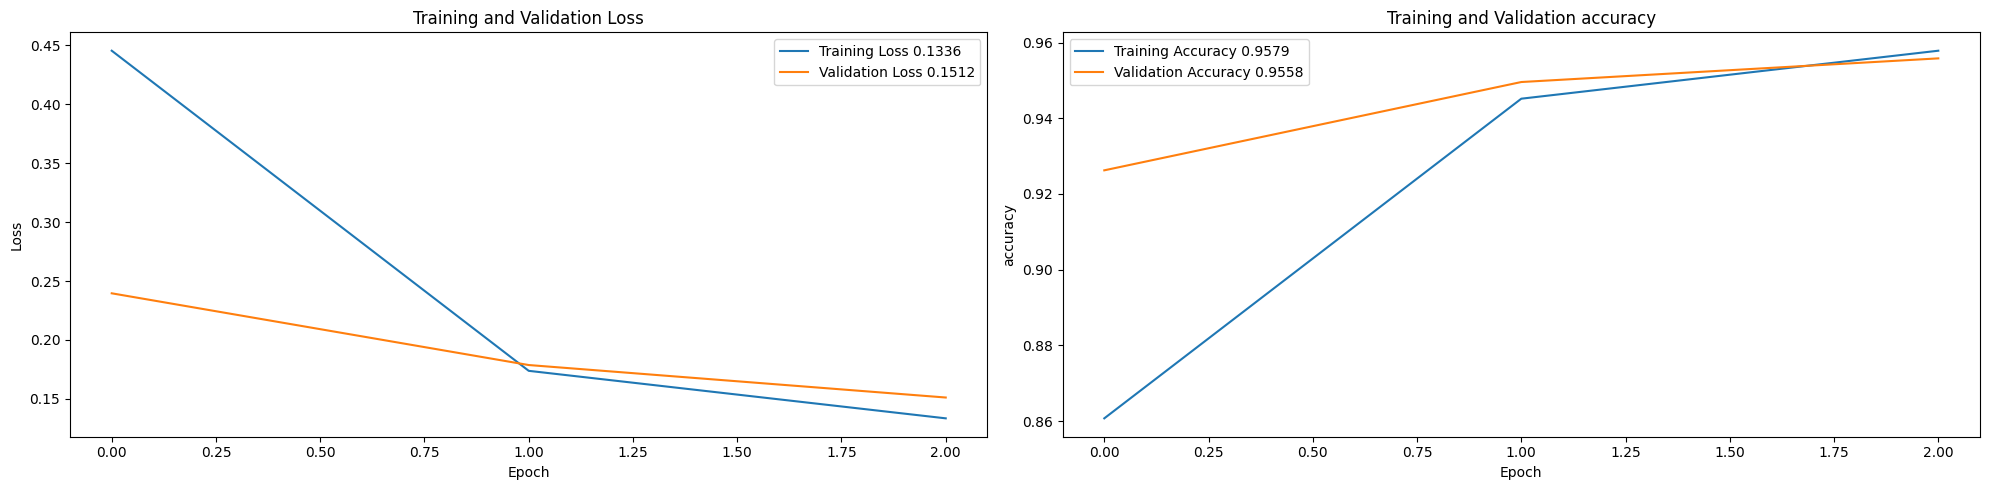

In [11]:
model_no = 0
# generating image data generators for training
train_data_gen = BatchSize(x_train.copy(), y_train.copy(), batch_size= h_batch_size[model_no]).standard_generator()
# generating image data generators for validation  
val_data_gen = BatchSize(x_validation.copy(), y_validation.copy(), batch_size= h_batch_size[model_no]).standard_generator()
    
# model architecture
model = sequential_model(convolutional_layers= h_convolutional_layer[model_no], 
                        neurons= h_neurons[model_no], 
                        activation= h_activation[model_no],
                        drop_neurons= h_drop_neurons[model_no])

# model compiler
model = compiler(model=model, 
                optimizer= h_optimizer[model_no], 
                learning_rate = h_learning_rate[model_no])

# model training
temp_model = modeltrainer(
                model= model, 
                x_train=x_train, 
                x_validation=x_validation, 
                train_generator=train_data_gen, 
                validation_generator=val_data_gen,
                epochs= h_num_epoch[model_no], 
                batch_size= h_batch_size[model_no],
                no_model= h_experiment[model_no]
                )

loss_accuracy_plot(temp_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 6, 6, 100)         1000      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 100)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 3, 3, 100)         0         
                                                                 
 flatten_3 (Flatten)         (None, 900)               0         
                                                                 
 dense_14 (Dense)            (None, 300)               270300    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                      

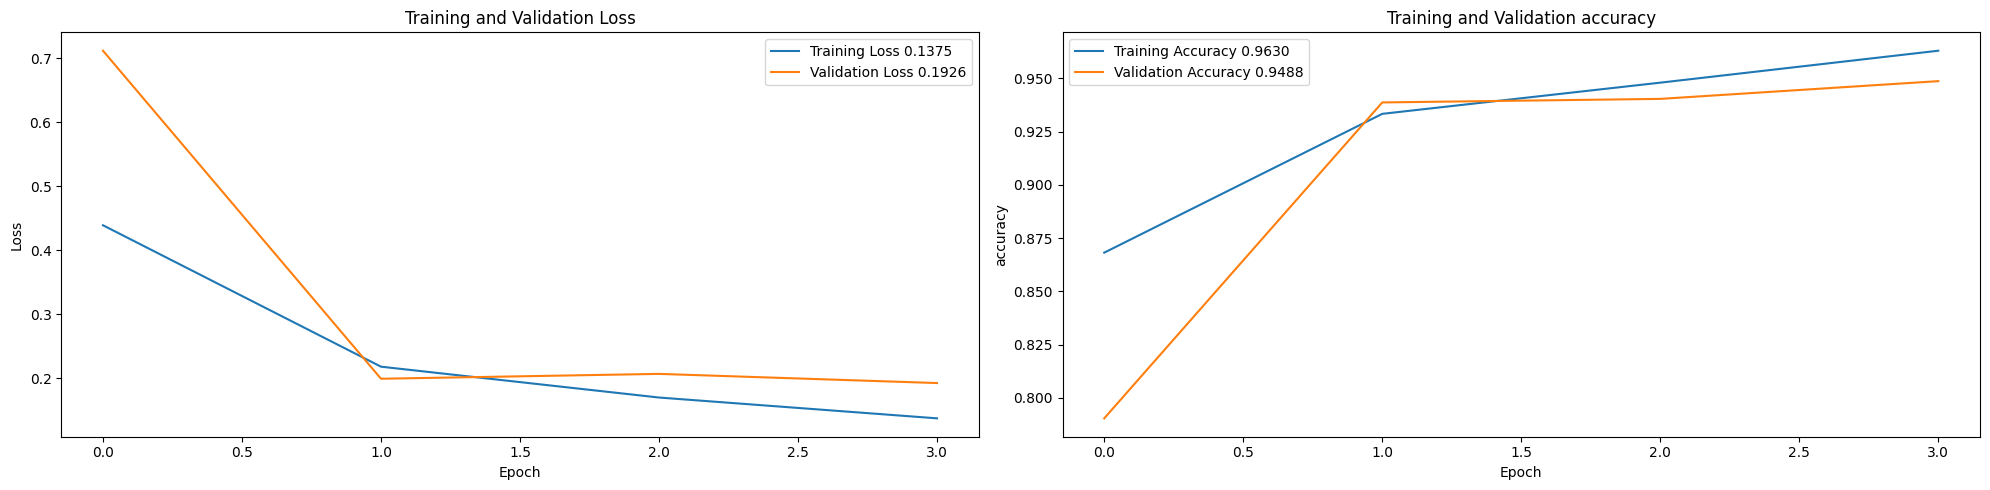

In [12]:
model_no = 1
# generating image data generators for training
train_data_gen = BatchSize(x_train.copy(), y_train.copy(), batch_size= h_batch_size[model_no]).standard_generator()
# generating image data generators for validation  
val_data_gen = BatchSize(x_validation.copy(), y_validation.copy(), batch_size= h_batch_size[model_no]).standard_generator()
    
# model architecture
model = sequential_model(convolutional_layers= h_convolutional_layer[model_no], 
                        neurons= h_neurons[model_no], 
                        activation= h_activation[model_no],
                        drop_neurons= h_drop_neurons[model_no])

# model compiler
model = compiler(model=model, 
                optimizer= h_optimizer[model_no], 
                learning_rate = h_learning_rate[model_no])

# model training
temp_model = modeltrainer(
                model= model, 
                x_train=x_train, 
                x_validation=x_validation, 
                train_generator=train_data_gen, 
                validation_generator=val_data_gen,
                epochs= h_num_epoch[model_no], 
                batch_size= h_batch_size[model_no],
                no_model= h_experiment[model_no]
                )

loss_accuracy_plot(temp_model)

### **6. Testing - Autoencoding and Image Classification**

--> Testing Accuracy: 0.9525


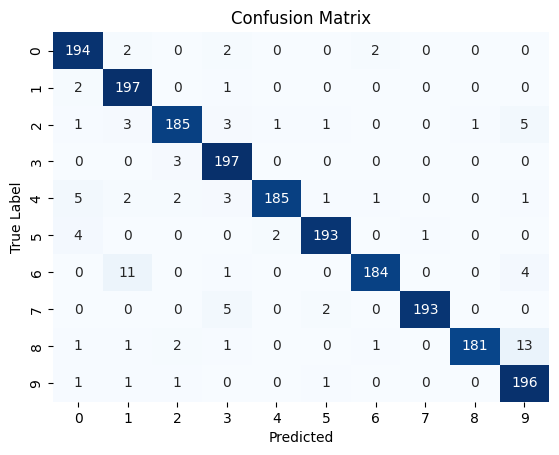

In [13]:
# encoding testing images
x_test = encoded_images(encoder_8p, images_dataset_testing.copy(), 8)
y_test = labels_dataset_testing.copy()

# Loading best image classification model
model = load_model('3) image_classification_models//model_1.h5')
predictions = model.predict(x_test, verbose=0)
predicted_class = np.argmax(predictions, axis=1)

print(f'--> Testing Accuracy: {accuracy_score(y_test, predicted_class)}')
# Creating confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(0,10), yticklabels=range(0,10), cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

/!\ Prediction Testing Image 768


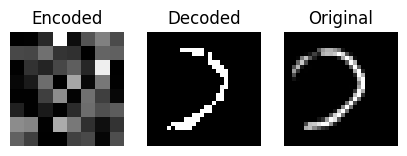

--> Validation: ✔ CORRECT!
--> Original Label: 7
--> Predicted Label: 7

/!\ Prediction Testing Image 1179


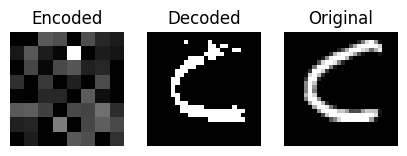

--> Validation: ✗ INCORRECT!
--> Original Label: 8
--> Predicted Label: 2

/!\ Prediction Testing Image 1584


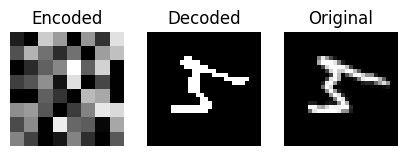

--> Validation: ✔ CORRECT!
--> Original Label: 3
--> Predicted Label: 3

/!\ Prediction Testing Image 1246


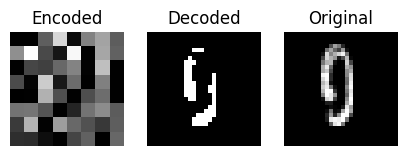

--> Validation: ✔ CORRECT!
--> Original Label: 5
--> Predicted Label: 5

/!\ Prediction Testing Image 1172


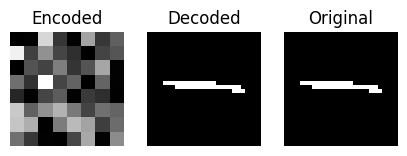

--> Validation: ✔ CORRECT!
--> Original Label: 1
--> Predicted Label: 1

/!\ Prediction Testing Image 376


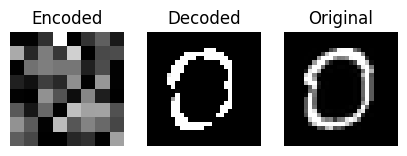

--> Validation: ✔ CORRECT!
--> Original Label: 5
--> Predicted Label: 5

/!\ Prediction Testing Image 700


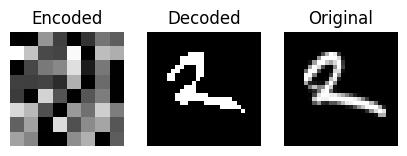

--> Validation: ✔ CORRECT!
--> Original Label: 9
--> Predicted Label: 9

/!\ Prediction Testing Image 1790


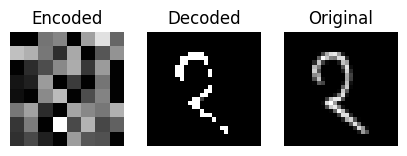

--> Validation: ✔ CORRECT!
--> Original Label: 9
--> Predicted Label: 9

/!\ Prediction Testing Image 1009


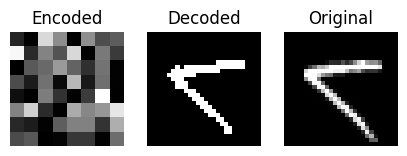

--> Validation: ✔ CORRECT!
--> Original Label: 8
--> Predicted Label: 8

/!\ Prediction Testing Image 1485


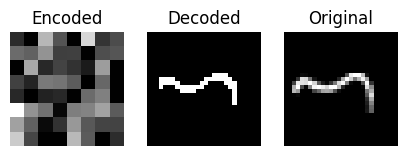

--> Validation: ✔ CORRECT!
--> Original Label: 4
--> Predicted Label: 4

/!\ Prediction Testing Image 184


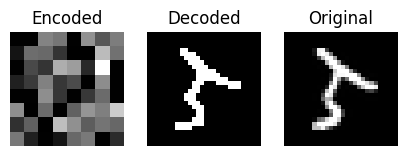

--> Validation: ✔ CORRECT!
--> Original Label: 3
--> Predicted Label: 3

/!\ Prediction Testing Image 457


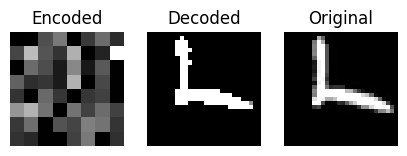

--> Validation: ✔ CORRECT!
--> Original Label: 6
--> Predicted Label: 6

/!\ Prediction Testing Image 555


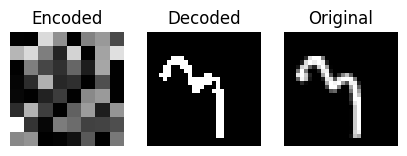

--> Validation: ✔ CORRECT!
--> Original Label: 4
--> Predicted Label: 4

/!\ Prediction Testing Image 397


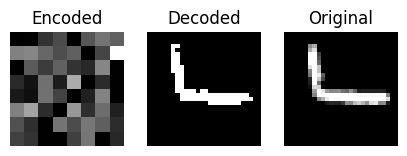

--> Validation: ✔ CORRECT!
--> Original Label: 6
--> Predicted Label: 6

/!\ Prediction Testing Image 306


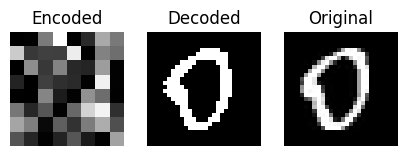

--> Validation: ✔ CORRECT!
--> Original Label: 5
--> Predicted Label: 5

/!\ Prediction Testing Image 1466


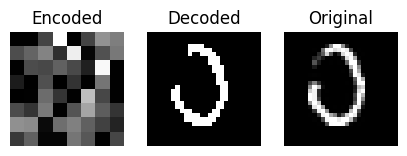

--> Validation: ✔ CORRECT!
--> Original Label: 5
--> Predicted Label: 5

/!\ Prediction Testing Image 251


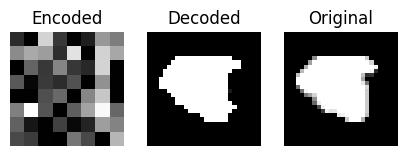

--> Validation: ✔ CORRECT!
--> Original Label: 0
--> Predicted Label: 0

/!\ Prediction Testing Image 1470


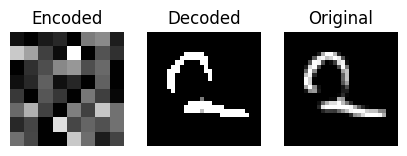

--> Validation: ✔ CORRECT!
--> Original Label: 9
--> Predicted Label: 9

/!\ Prediction Testing Image 1700


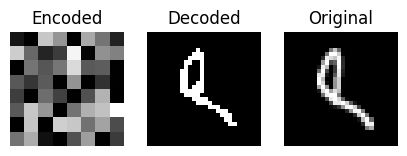

--> Validation: ✔ CORRECT!
--> Original Label: 9
--> Predicted Label: 9

/!\ Prediction Testing Image 673


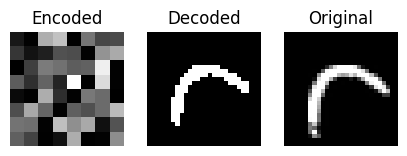

--> Validation: ✔ CORRECT!
--> Original Label: 2
--> Predicted Label: 2



In [14]:
# create image dictionary
images_tested = [x_test, decoded_images(decoder_8p, x_test.copy()), images_dataset_testing.reshape(-1, 28, 28)]

# create array label-prediction results
comparison_array = np.array([np.array_equal(y, p) for y, p in zip(y_test, predicted_class)])
comparison_array = ["✔ CORRECT!" if comparison_array[index] == True else "✗ INCORRECT!" for index in range(len(comparison_array))]

# get 20 random indexes 
indexes = [random.randint(0, 1999) for _ in range(20)]

# plot testing images and predictions
for index in indexes: 
    print(f'/!\ Prediction Testing Image {index+1}')
        
    title = ['Encoded', 'Decoded', 'Original']

    plt.figure(figsize=(5, 5))  
    for i, title in zip(range(3), title):
        plt.subplot(1, 3, i+1)
        plt.imshow(images_tested[i][index], cmap='gray') 
        plt.title(title)
        plt.axis('off')  

    plt.show()
    
    print(f'--> Validation: {comparison_array[index]}')
    print(f'--> Original Label: {y_test[index]}')
    print(f'--> Predicted Label: {predicted_class[index]}')
    print('=====================================================\n')
